In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import re
import datetime as dt
from tqdm import tqdm
import matplotlib.pyplot as plt

'''#import plotly for interactive chart
import plotly.plotly as py
import plotly
plotly.tools.set_credentials_file(username='richwolff', api_key='v0qPC120X33yPvAMDQXi')
from plotly.graph_objs import * '''

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

from collections import defaultdict
%matplotlib inline

<h2>Load books into dataframe</h2>

In [2]:
d = defaultdict(list)

strtofind = r'";"'
with open('../data/raw/BX-Books.csv','r',encoding='8859') as file:
    for i,line in enumerate(file):
        d[i] = re.sub(strtofind,'||',line.replace('&amp;','&')).replace('"','').replace('\n','').split('||')
        
books_df = pd.DataFrame(data=list(d.values())[1:],index=list(d.keys())[1:],columns=d[0])
del d

In [3]:
## https://en.wikipedia.org/wiki/List_of_ISBN_identifier_groups
def book_lan_nationality(x):
    if x in ('0','1'):
        return 'English'
    elif not x in ('2','3','4','5','7'):
        return 'Other'
    elif x == '2':
        return 'French'
    elif x == '3':
        return 'German'
    elif x == '4':
        return 'Japan'
    elif x == '5': 
        return 'former USSR'
    elif x == '7': 
        return 'China'
    return None

books_df['origin'] = books_df['ISBN'].str.slice(0,1).apply(book_lan_nationality)
books_df['1st_3_publisher'] =books_df['ISBN'].str.slice(0,4).apply(lambda x: x[1:4] if x[0] in ('0','1','2','3','4','5','7') else 'Other')
books_df.sort_values(['origin','1st_3_publisher']).head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,origin,1st_3_publisher
243630,706400402X,Oriental Rugs and Carpets,Stanley Reed,0,Octopus Books,http://images.amazon.com/images/P/706400402X.0...,http://images.amazon.com/images/P/706400402X.0...,http://images.amazon.com/images/P/706400402X.0...,China,064
79353,7108009153,Zi ben zhu yi yu er shi yi shi ji,Ray Huang,1997,Jing xiao Xin hua shu dian,http://images.amazon.com/images/P/7108009153.0...,http://images.amazon.com/images/P/7108009153.0...,http://images.amazon.com/images/P/7108009153.0...,China,108
226475,710800982X,Wan li shi wu nian (Huang Renyu zuo pin xi lie),Ray Huang,1997,Jing xiao Xin hua shu dian,http://images.amazon.com/images/P/710800982X.0...,http://images.amazon.com/images/P/710800982X.0...,http://images.amazon.com/images/P/710800982X.0...,China,108
19579,7119020412,Tales From Ancient China's Imperial Harem,Yuan Yang,1998,Foreign Languages Press,http://images.amazon.com/images/P/7119020412.0...,http://images.amazon.com/images/P/7119020412.0...,http://images.amazon.com/images/P/7119020412.0...,China,119
125185,711900557X,"The pocket interpreter, Chinese",Lydia Chen,1988,Foreign Languages Press,http://images.amazon.com/images/P/711900557X.0...,http://images.amazon.com/images/P/711900557X.0...,http://images.amazon.com/images/P/711900557X.0...,China,119


<H2> Load Users Into DF </H2>

In [4]:
## Load users file and display first 5 rows
users_df = pd.read_csv('../data/raw/BX-Users.csv',sep=';',encoding='8859')
users_df.tail(5)

,User-ID,Location,Age
278853,278854,"portland, oregon, usa",NaN
278854,278855,"tacoma, washington, united kingdom",50.0
278855,278856,"brampton, ontario, canada",NaN
278856,278857,"knoxville, tennessee, usa",NaN
278857,278858,"dublin, n/a, ireland",NaN


<h3>There may be similarities of books read within certain age ranges. I'll create a category of age ranges to see if we can increase the accuracy of our model</h3>

(0, 100)

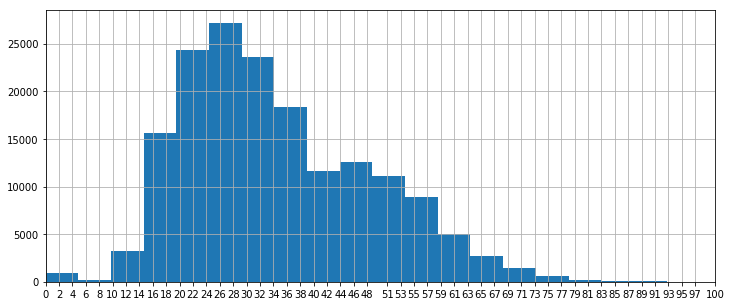

In [5]:
users_df['Age'].hist(bins=50,figsize=(12,5))
plt.xticks(np.linspace(0,100,50,dtype=np.int));
plt.xlim(0,100)

Age Ranges:
<ul>
<LI>LT 16</LI><LI>16 - 20</LI><LI>20 - 30</LI><LI>30 - 40</LI><LI>40 - 55</LI><LI>55+</LI>
</UL>

In [6]:
def age_range(x):
    if x < 16:
        return 'LT 16'
    elif x >=16 and x < 20:
        return '16-20'
    elif x >=20 and  x < 30:
        return '20-30'
    elif x >=30 and x < 40:
        return '20-40'
    elif x >=40 and x < 55:
        return '40-55'
    elif x >= 55:
        return 'GT 55'
    else:
        return 'Unknown'
users_df['age_range'] = users_df['Age'].apply(age_range)

<h2>Load User Ratings Of Books</h2>

In [7]:
ratings_df = pd.read_csv('../data/raw/BX-Book-Ratings.csv',sep=';',encoding='8859',dtype={'Book-Rating':np.int}).sort_values('User-ID')
ratings_df.head()

,User-ID,ISBN,Book-Rating
9561,2,0195153448,0
9562,7,034542252,0
9572,8,0771025661,0
9580,8,1881320189,7
9579,8,1575663937,6


In [8]:
## Join user and book data to ratings data
ratings = ratings_df.set_index('User-ID').join(users_df.set_index('User-ID')).reset_index().set_index('ISBN').join(books_df.set_index('ISBN'))

## Split out users from the USA
us_ratings = ratings[(ratings['Location'].str.lower().str.contains('usa')) | (ratings['Location'].str.lower().str.contains('states'))].reset_index()
us_ratings.head()

bk_platform_popularity = us_ratings.groupby('ISBN')['User-ID'].count().rename('platform_popularity')

<h2>Drop books that have only been read once. These can not be used for good recommendations</h2>

In [9]:
# How many times a book must have been read to keep it in ratings
min_book_read_count = 3

isbn_val_counts = us_ratings['ISBN'].value_counts()
books_to_keep = set(isbn_val_counts[isbn_val_counts>=min_book_read_count].index)

filtered_us_ratings = us_ratings[us_ratings['ISBN'].isin(books_to_keep)]

<h2>Split data into training and test sets</h2>

In [10]:
ratings_us_training,ratings_us_test = train_test_split(filtered_us_ratings,test_size=.20,random_state=21)

In [11]:
ratings_us_training.head()

,ISBN,User-ID,Book-Rating,Location,Age,age_range,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,origin,1st_3_publisher
17430,0060809507,199515,0,"la cienega, new mexico, usa",44.0,40-55,People of Darkness,Tony Hillerman,1988,Perennial,http://images.amazon.com/images/P/0060809507.0...,http://images.amazon.com/images/P/0060809507.0...,http://images.amazon.com/images/P/0060809507.0...,English,060
484802,0553801910,73436,9,"salem, oregon, usa",54.0,40-55,Keeping Watch,LAURIE R. KING,2003,Bantam,http://images.amazon.com/images/P/0553801910.0...,http://images.amazon.com/images/P/0553801910.0...,http://images.amazon.com/images/P/0553801910.0...,English,553
427874,051512902X,69697,0,"west sacramento, california, usa",24.0,20-30,After Dark,Jayne Castle,2000,Jove Books,http://images.amazon.com/images/P/051512902X.0...,http://images.amazon.com/images/P/051512902X.0...,http://images.amazon.com/images/P/051512902X.0...,English,515
619014,078600049X,167800,0,"olive branch, mississippi, usa",57.0,GT 55,More Than Magic,Olga Bicos,1994,Pinnacle Books,http://images.amazon.com/images/P/078600049X.0...,http://images.amazon.com/images/P/078600049X.0...,http://images.amazon.com/images/P/078600049X.0...,English,786
596281,0743237188,63938,6,"northwest, iowa, usa",NaN,Unknown,Fall On Your Knees (Oprah #45),Ann-Marie MacDonald,2002,Touchstone,http://images.amazon.com/images/P/0743237188.0...,http://images.amazon.com/images/P/0743237188.0...,http://images.amazon.com/images/P/0743237188.0...,English,743


<h2>Insert data into graph data structure</h2>

In [12]:
import datetime as dt
user_nodes = set(ratings_us_training['User-ID'].unique())
book_nodes = set(ratings_us_training['ISBN'].unique())

# Build the graph structure from pandas data frame
G = nx.from_pandas_edgelist(ratings_us_training,'User-ID','ISBN',['Book-Rating'])

# Compute DCS
dcs = nx.bipartite.degree_centrality(G,user_nodes)

# Add Meta Data
for i,row in ratings_us_training.iterrows():
    user_node = G.node[row['User-ID']]
    book_node = G.node[row['ISBN']]
    
    user_node['age_range'] = row['age_range']
    user_node['Location'] = row['Location']
    user_node['bipartite'] = 'user'
    user_node['dcs'] = dcs[row['User-ID']]
    
    book_node['origin'] = row['origin']
    book_node['isbn_1st_3'] = row['1st_3_publisher']
    book_node['bipartite'] = 'book'
    book_node['Book-Title'] = row['Book-Title']
    book_node['Book-Author'] = row['Book-Author']
    book_node['Publisher'] = row['Publisher']
    book_node['Publication_Year'] = row['Year-Of-Publication']
    book_node['dcs'] = dcs[row['ISBN']]

<h2>Create a user and book biadjacency matrix with users as rows and books as columns </h2>

In [13]:
#using the rating as weight to add weight to explicit reviews to similarity scores
user_arr = np.array(list(user_nodes))
books_arr = np.array(list(book_nodes))
user_adj_matrix = nx.bipartite.biadjacency_matrix(G,row_order=user_nodes,column_order=book_nodes,weight='Book-Rating')

<h2>Create a user x user matrix with the cosine similarities as their intersection value</h2>

In [14]:
# Take cosine similarities of users based on ratings they've given each book (column)
user_sims = cosine_similarity(user_adj_matrix,dense_output=False)
user_sims.setdiag(0)
user_sims_coo = user_sims.tocoo()

/Users/danielle/anaconda/lib/python3.6/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [15]:
def collaborative_filter(selected_user,node_list,user_matrix,top_n_similarities):
    '''Our collaborative filter accepts a selected user, list of user nodes used to create the 
    user coordinate matrix, the user x user coordinate matrix, and the Number of top simililarities
    to return for the collaborative filter. The filter looks for users who have read similar books and returns
    a data frame the books, average user similarity, number of times the book has been read by those similar to you.
    
    input
        selected_user: integer of user id
        node_list: numpy array of users
        user_matrix: scipy.sparse.coo.coo_matrix of user x user matrix
        top_n_similarities: # of similarities to pull from (Only pull from users that are most similar)
    
    returns
        pd.DataFrame with user id and isbn number as index with the books average rating, sum of user similarity,
        average user similarity, # of times the book has been read/bought by users who read at least 1 book the 
        selected user read, sum of book ratings, average book ratings, # of explicit and implicit ratings, & average
        explicit rating 
    
    '''
    def node_similiarities(node, node_list, matrix):
        '''Creates a numpy array of node similiarities (user or books)'''
        node_agerange = G.node[node]['age_range']
        indices = np.where(matrix.row == np.where(node_list==node)[0])[0]
        matrix_sims_node = []
        matrix_sims_score = []
        nodes_sim = defaultdict(list)
        for idx in indices:
            neighbor = node_list[matrix.col[idx]]
            #if G.node[neighbor]['age_range'] == node_agerange:
            cos_sim = (matrix.data[idx])
            nodes_sim[cos_sim].append(neighbor)
        return nodes_sim
    
    def user_neighbor_books(selected_user, user_similarity_dict,top_n_similarities):
        '''accepts a 2d array with users in the first column and similarities in the 2nd
           returns top 10 books with scores'''
        books = defaultdict(lambda: defaultdict(float))
        for key in sorted(user_similarity_dict.keys(),reverse=True)[:top_n_similarities]:
            for usr_lookup in user_similarity_dict[key]:
                for bk in set(G.neighbors(usr_lookup)).difference(G.neighbors(selected_user)):
                    book_rating = G[usr_lookup][bk]['Book-Rating']
                    books[bk]['count'] += 1
                    books[bk]['cosine'] += key
                    books[bk]['rating'] += book_rating
                    books[bk]['implicit_ratings'] += 1 if book_rating == 0 else 0
                    books[bk]['explicit_ratings'] += 1 if book_rating > 0 else 0
                    books[bk]['avg_cosine'] = books[bk]['cosine']/books[bk]['count']  
                    books[bk]['avg_rating'] = books[bk]['rating']/books[bk]['count']
                    if books[bk]['explicit_ratings'] > 0:
                        books[bk]['avg_explicit_rating'] = books[bk]['rating']/books[bk]['explicit_ratings']
                    if books[bk]['implicit_ratings'] > 0:
                        books[bk]['explicit_implicit_ratio'] = books[bk]['explicit_ratings']/books[bk]['implicit_ratings']
        
        return books
    
    def books_dict_to_df(books_list):
        books_list = [(b,
               d['avg_rating'],
               d['avg_explicit_rating'],        
               d['avg_cosine'],
               d['explicit_implicit_ratio'],
               d['count'],
               d['cosine'],
               d['rating'],
               d['implicit_ratings']) for b,d in zip(user_books_df.keys(),user_books_df.values())]
        df_columns = ['ISBN','avg_rating','avg_explicit_rating','avg_cosine','explicit_implicit_ratio','user_count','cosines','ratings','implicit_ratings']
        ret_df = pd.DataFrame(books_list,columns=df_columns)
        ret_df['user'] = selected_user
        return ret_df


    user_sims_nodes = node_similiarities(selected_user,user_arr,user_sims_coo)
    
    user_books_df = user_neighbor_books(selected_user=selected_user,
                                        user_similarity_dict=user_sims_nodes,
                                        top_n_similarities=top_n_similarities)
    
    res = books_dict_to_df(user_books_df).set_index('ISBN').join(bk_platform_popularity).reset_index()
    
    return res.set_index(['user','ISBN'])


<h2>Test 1 User On Collaborative Filter</h2>

In [16]:
selected_user = 278418     
def collab_filter_recommendations(selected_user,n_recommendations=None,top_n_sim=25):
    ''' Accepts the selected user and total n_recommendations to return. 
        Returns the dataframe in collaborative_filter with if the user actually read the book or not'''
    recommended_books = collaborative_filter(selected_user,user_arr,user_sims_coo,top_n_sim)
    recommended_books = recommended_books.sort_values(['user_count','cosines'],ascending=False)
    recommended_books = recommended_books.head(n_recommendations)

    # Pull actual purchases
    sel_user_actual = ratings_us_test[ratings_us_test['User-ID']==selected_user]['ISBN'].to_frame()
    sel_user_actual['read'] = 1
    sel_user_actual['user'] = selected_user
    sel_user_actual.set_index(['user','ISBN'],inplace=True)

    # TOP N Recommendation based on cosines
    return recommended_books.join(sel_user_actual).fillna(0)

collab_filter_recommendations(selected_user).head(10)

avg_rating  avg_explicit_rating  avg_cosine  \
user   ISBN                                                      
278418 0515132020    7.000000             9.333333    0.109906   
       0971880107    1.666667             5.000000    0.142279   
       0345391802    0.000000             0.000000    0.133490   
       0316899984    0.000000             0.000000    0.133490   
       051513287X    4.000000             8.000000    0.132706   
       0312983271    0.000000             0.000000    0.123221   
       0440221471    3.500000             7.000000    0.122135   
       0345413881    0.000000             0.000000    0.112740   
       0553583441    2.500000             5.000000    0.104472   
       0446608815    3.500000             7.000000    0.101598   

                   explicit_implicit_ratio  user_count   cosines  ratings  \
user   ISBN                                                                 
278418 0515132020                      3.0         4.0  0.439626     28.0   
       0971880107                      0.5         3.0  0.426838      5.0   
       0345391802                      0.0         2.0  0.266979      0.0   
       0316899984                      0.0         2.0  0.266979      0.0   
       051513287X                      1.0         2.0  0.265411      8.0   
       0312983271                      0.0         2.0  0.246442      0.0   
       0440221471                      1.0         2.0  0.244270      7.0   
       0345413881                      0.0         2.0  0.225480      0.0   
       0553583441                      1.0         2.0  0.208944      5.0   
       0446608815                      1.0         2.0  0.203196      7.0   

                   implicit_ratings  platform_popularity  read  
user   ISBN                                                     
278418 0515132020               1.0                  170   0.0  
       0971880107               2.0                 1202   0.0  
       0345391802               2.0                  100   0.0  
       0316899984               2.0                  148   0.0  
       051513287X               1.0                  192   0.0  
       0312983271               2.0                  199   0.0  
       0440221471               1.0                  354   0.0  
       0345413881               2.0                  103   0.0  
       0553583441               1.0                   83   0.0  
       0446608815               1.0                  140   0.0

<h2>Take 75% of ratings from test set, train the model then test on the 25% of ratings</h2>

In [17]:
#Filter on number of books a user read in test set
test_ratings_user_count = 25

test_ratings_user_valcount = ratings_us_test['User-ID'].value_counts()
filtered_test_ratings = test_ratings_user_valcount[test_ratings_user_valcount>test_ratings_user_count]


## Split test set to random forest training and test set

train_ratings,test_ratings = train_test_split(filtered_test_ratings,test_size=.25)
users_to_train = train_ratings.index.values
users_to_test = test_ratings.index.values

In [18]:
top_n_cosines = 10
n_recommendations = 300

metrics = np.empty(len(users_to_train))

group_df = []

for i,sel_user in enumerate(users_to_train):
    group_df.append(collab_filter_recommendations(sel_user,n_recommendations,top_n_sim=top_n_cosines))
    
group_df = pd.concat(group_df).fillna(0)    

In [19]:
group_df.head(20)
X = group_df.drop(['read'],axis=1)
y = group_df['read']
print(X.shape)

(49785, 9)


<h2>Import sklearn items</h2>

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, precision_score

<h2>Logistic Regression</h2>

In [21]:
# Log reg model
lr = LogisticRegression()
lr.fit(X,y)

log_reg_coefs = pd.DataFrame(lr.coef_,columns=X.columns).T.sort_values(0,ascending=False)

y_pred = lr.predict(X)
y_pred_proba = lr.predict_proba(X)[:,1]
fpr,tpr,thresholds = roc_curve(y,y_pred)

In [22]:
print('Log Reg Confusion Matrix\n')
print(pd.crosstab(y,lr.predict(X), rownames=['True'], colnames=['Predicted'],))

Log Reg Confusion Matrix

Predicted    0.0  1.0
True                 
0.0        48606   30
1.0         1115   34


In [23]:
print('Log Reg Classification Report\n')
print(classification_report(y,y_pred,target_names=['Not Read','Read']))

Log Reg Classification Report

             precision    recall  f1-score   support

   Not Read       0.98      1.00      0.99     48636
       Read       0.53      0.03      0.06      1149

avg / total       0.97      0.98      0.97     49785



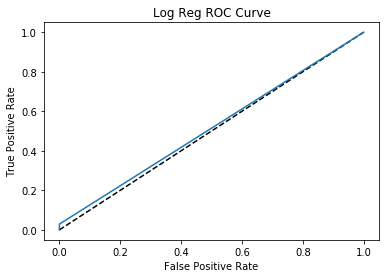

In [24]:
plt.plot([0,1],[0,1],'k--');
plt.plot(fpr,tpr, label='Log Reg');
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('Log Reg ROC Curve');

<h2>Logistic regression over predicts books that are not purchased/read as not purchased/read. With our goal being to recommend the books that users would want to buy, we need to maximize that metric.</h2><br>
<h2>Next, we'll try a random forest classifier</h2>

In [25]:
## Random forests classifier using randomized grid search to find best parameters
def scoring(model,x,y):
    y_pred = model.predict(x)
    return precision_score(y,y_pred,pos_label=1)

params = {'n_estimators':np.linspace(1,100,100,dtype=np.int),
          'min_samples_split':[2,3,4,5,6,7,8],
          'criterion':['gini','entropy'],
          'min_samples_leaf':[1,2,3,4,5,6,7],}

rfc = RandomForestClassifier()
rfcgrid = RandomizedSearchCV(rfc,params,scoring=scoring,n_iter=50,n_jobs=-1)
rfcgrid.fit(X,y)

best__n_estimators = rfcgrid.best_params_['n_estimators']
best__criterion = rfcgrid.best_params_['criterion']
best__min_samples_leaf = rfcgrid.best_params_['min_samples_leaf']
best__min_samples_split = rfcgrid.best_params_['min_samples_split']
print('Random Forests Grid Search')

print('Best Random Forests grid search score: {:.4f}'.format(rfcgrid.best_score_))
print('''Best n_estimators: {:.4f} 
Best Criterion: {} 
Best min_samples_leaf: {}
Best min_samples_split: {}'''.format(best__n_estimators,
                                     best__criterion,
                                     best__min_samples_leaf,
                                     best__min_samples_split),end='\n\n')


Random Forests Grid Search
Best Random Forests grid search score: 0.4907
Best n_estimators: 77.0000 
Best Criterion: entropy 
Best min_samples_leaf: 7
Best min_samples_split: 2



In [26]:
## Fit actual RFC model with best parameters from grid search

rfc = RandomForestClassifier(n_estimators=best__n_estimators,
                             criterion=best__criterion,
                             min_samples_leaf=best__min_samples_leaf,
                             min_samples_split=best__min_samples_split,
                             n_jobs=-1)
rfc.fit(X,y)

y_pred = rfc.predict(X)
y_pred_proba = rfc.predict_proba(X)[:,1]
fpr,tpr,thresholds = roc_curve(y,y_pred)

In [27]:
print('Random Forests Confusion Matrix\n')
print(pd.crosstab(y,y_pred, rownames=['True'], colnames=['Predicted'],))

Random Forests Confusion Matrix

Predicted    0.0  1.0
True                 
0.0        48625   11
1.0         1098   51


In [28]:
print('Random Forests Classification Report\n')
print(classification_report(y,y_pred,target_names=['Not Read','Read']))

Random Forests Classification Report

             precision    recall  f1-score   support

   Not Read       0.98      1.00      0.99     48636
       Read       0.82      0.04      0.08      1149

avg / total       0.97      0.98      0.97     49785



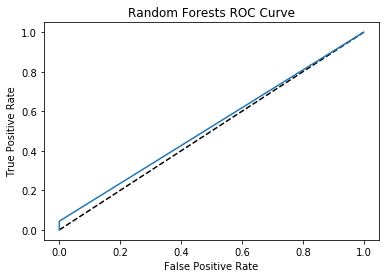

In [29]:
plt.plot([0,1],[0,1],'k--');
plt.plot(fpr,tpr, label='Random Forests');
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('Random Forests ROC Curve');

In [30]:
print('Feature Importancs\n')
print(pd.Series(rfc.feature_importances_,X.columns).sort_values(ascending=False))

Feature Importancs

platform_popularity        0.308313
cosines                    0.252225
avg_cosine                 0.238934
user_count                 0.060145
ratings                    0.059407
avg_explicit_rating        0.036604
avg_rating                 0.032075
implicit_ratings           0.007047
explicit_implicit_ratio    0.005250
dtype: float64


In [31]:
print('Random Forests Cross Val Score on Precision Metric')
def scoring(model,X,y):
    y_pred=model.predict(X)
    return precision_score(y,y_pred,labels=['Not read','Read'],pos_label=1)

print('Overall model score: {:.3f}'.format(scoring(rfc,X,y),end='\n\n'))
print('Cross Validated Model Scores: {}'.format(cross_val_score(rfc,X,y,scoring=scoring,cv=3)))

Random Forests Cross Val Score on Precision Metric
Overall model score: 0.823
Cross Validated Model Scores: [0.6       0.1509434 0.5      ]


<h2>Test on hold out data</h2>

In [32]:
## Build dataframe of Recommended books from holdout data
group_df = []

for i,sel_user in enumerate(users_to_test):
    group_df.append(collab_filter_recommendations(sel_user,n_recommendations,top_n_sim=top_n_cosines))
    
group_df = pd.concat(group_df).fillna(0)    

In [33]:
## Break collaborative filter into recommendations
X_test = group_df.drop(['read'],axis=1)
y_test = group_df['read']

In [34]:
## Get the precision of hold out data in Random Forests Classifier
holdout_score = precision_score(y_test,rfc.predict(X_test),labels=['Not read','Read'])
print('Holdout Data Precision Score: {:.3f}'.format(holdout_score))

Holdout Data Precision Score: 0.833


<h2>Pull individual recommendations for users using Random Forest Classifer</h2>

In [35]:
def recommender(model,usr,top_n=10):
    user_recommendations = collab_filter_recommendations(usr)
    
    if len(user_recommendations) > 0:
        X_sample = user_recommendations.drop(['read'],axis=1)
        user_recommendations['predicted'] = model.predict(X_sample)
        return user_recommendations.sort_values(['predicted','cosines'],ascending=False)[:top_n]
    
    return "No Recommendations"

In [36]:
selected_user = 278418
res = recommender(rfc,selected_user,10)
res

avg_rating  avg_explicit_rating  avg_cosine  \
user   ISBN                                                      
278418 0515132020    7.000000             9.333333    0.109906   
       0971880107    1.666667             5.000000    0.142279   
       0345391802    0.000000             0.000000    0.133490   
       0316899984    0.000000             0.000000    0.133490   
       051513287X    4.000000             8.000000    0.132706   
       0312983271    0.000000             0.000000    0.123221   
       0440221471    3.500000             7.000000    0.122135   
       0345413881    0.000000             0.000000    0.112740   
       0553583441    2.500000             5.000000    0.104472   
       0446608815    3.500000             7.000000    0.101598   

                   explicit_implicit_ratio  user_count   cosines  ratings  \
user   ISBN                                                                 
278418 0515132020                      3.0         4.0  0.439626     28.0   
       0971880107                      0.5         3.0  0.426838      5.0   
       0345391802                      0.0         2.0  0.266979      0.0   
       0316899984                      0.0         2.0  0.266979      0.0   
       051513287X                      1.0         2.0  0.265411      8.0   
       0312983271                      0.0         2.0  0.246442      0.0   
       0440221471                      1.0         2.0  0.244270      7.0   
       0345413881                      0.0         2.0  0.225480      0.0   
       0553583441                      1.0         2.0  0.208944      5.0   
       0446608815                      1.0         2.0  0.203196      7.0   

                   implicit_ratings  platform_popularity  read  predicted  
user   ISBN                                                                
278418 0515132020               1.0                  170   0.0        0.0  
       0971880107               2.0                 1202   0.0        0.0  
       0345391802               2.0                  100   0.0        0.0  
       0316899984               2.0                  148   0.0        0.0  
       051513287X               1.0                  192   0.0        0.0  
       0312983271               2.0                  199   0.0        0.0  
       0440221471               1.0                  354   0.0        0.0  
       0345413881               2.0                  103   0.0        0.0  
       0553583441               1.0                   83   0.0        0.0  
       0446608815               1.0                  140   0.0        0.0

In [37]:
selected_user = 111422
res = recommender(rfc,selected_user)
res

avg_rating  avg_explicit_rating  avg_cosine  \
user   ISBN                                                      
111422 0804113475         0.0                  0.0    0.281381   
       0385318375         7.0                  7.0    0.281381   
       0671023373         0.0                  0.0    0.281381   
       0393009254         0.0                  0.0    0.281381   
       0805063897         9.0                  9.0    0.281381   
       0679776818         6.0                  6.0    0.281381   
       067976657X         8.0                  8.0    0.281381   
       0385508417         0.0                  0.0    0.281381   
       0451131517         0.0                  0.0    0.281381   
       0874772095         0.0                  0.0    0.281381   

                   explicit_implicit_ratio  user_count   cosines  ratings  \
user   ISBN                                                                 
111422 0804113475                      0.0         1.0  0.281381      0.0   
       0385318375                      0.0         1.0  0.281381      7.0   
       0671023373                      0.0         1.0  0.281381      0.0   
       0393009254                      0.0         1.0  0.281381      0.0   
       0805063897                      0.0         1.0  0.281381      9.0   
       0679776818                      0.0         1.0  0.281381      6.0   
       067976657X                      0.0         1.0  0.281381      8.0   
       0385508417                      0.0         1.0  0.281381      0.0   
       0451131517                      0.0         1.0  0.281381      0.0   
       0874772095                      0.0         1.0  0.281381      0.0   

                   implicit_ratings  platform_popularity  read  predicted  
user   ISBN                                                                
111422 0804113475               1.0                   51   0.0        0.0  
       0385318375               0.0                   12   0.0        0.0  
       0671023373               1.0                   15   0.0        0.0  
       0393009254               1.0                    3   0.0        0.0  
       0805063897               0.0                  227   0.0        0.0  
       0679776818               0.0                   32   0.0        0.0  
       067976657X               0.0                   15   0.0        0.0  
       0385508417               1.0                   86   0.0        0.0  
       0451131517               1.0                   30   0.0        0.0  
       0874772095               1.0                   10   0.0        0.0

In [38]:
selected_user = 35859
res = recommender(rfc,selected_user)
res

avg_rating  avg_explicit_rating  avg_cosine  \
user  ISBN                                                      
35859 0312966970    8.750000             8.750000    0.064815   
      0312976275    8.666667             8.666667    0.063658   
      0312980140    9.000000             9.000000    0.063452   
      0440241073    4.000000             8.000000    0.066763   
      0061042935    0.000000             0.000000    0.066736   
      0451177037    4.500000             9.000000    0.066736   
      0553576798    0.000000             0.000000    0.062256   
      0439136369    5.000000            10.000000    0.062256   
      0440213525    4.500000             9.000000    0.062256   
      0064408272    5.000000             5.000000    0.083918   

                  explicit_implicit_ratio  user_count   cosines  ratings  \
user  ISBN                                                                 
35859 0312966970                      0.0         4.0  0.259260     35.0   
      0312976275                      0.0         3.0  0.190974     26.0   
      0312980140                      0.0         3.0  0.190357     27.0   
      0440241073                      1.0         2.0  0.133526      8.0   
      0061042935                      0.0         2.0  0.133473      0.0   
      0451177037                      1.0         2.0  0.133473      9.0   
      0553576798                      0.0         2.0  0.124512      0.0   
      0439136369                      1.0         2.0  0.124512     10.0   
      0440213525                      1.0         2.0  0.124512      9.0   
      0064408272                      0.0         1.0  0.083918      5.0   

                  implicit_ratings  platform_popularity  read  predicted  
user  ISBN                                                                
35859 0312966970               0.0                  180   0.0        1.0  
      0312976275               0.0                  155   0.0        0.0  
      0312980140               0.0                  162   1.0        0.0  
      0440241073               1.0                  344   1.0        0.0  
      0061042935               2.0                   41   0.0        0.0  
      0451177037               1.0                   26   0.0        0.0  
      0553576798               2.0                   61   0.0        0.0  
      0439136369               1.0                  188   0.0        0.0  
      0440213525               1.0                  291   0.0        0.0  
      0064408272               0.0                    6   0.0        0.0

In [39]:
selected_user = 153662
res = recommender(rfc,selected_user)
res

avg_rating  avg_explicit_rating  avg_cosine  \
user   ISBN                                                      
153662 0515128554    7.750000                 7.75    0.098757   
       0553285785    4.285714                 7.50    0.098095   
       0373218192    4.142857                 7.25    0.089713   
       0515114006    7.800000                 7.80    0.113574   
       0373483503    6.600000                 8.25    0.101868   
       0425191583    7.000000                 7.00    0.098712   
       0515132187    6.000000                 9.00    0.077172   
       0425176304    6.250000                 6.25    0.108330   
       0399147128    8.500000                 8.50    0.099434   
       042517140X    6.800000                 8.50    0.078362   

                   explicit_implicit_ratio  user_count   cosines  ratings  \
user   ISBN                                                                 
153662 0515128554                 0.000000         8.0  0.790053     62.0   
       0553285785                 1.333333         7.0  0.686666     30.0   
       0373218192                 1.333333         7.0  0.627990     29.0   
       0515114006                 0.000000         5.0  0.567870     39.0   
       0373483503                 4.000000         5.0  0.509338     33.0   
       0425191583                 0.000000         5.0  0.493558     35.0   
       0515132187                 2.000000         6.0  0.463035     36.0   
       0425176304                 0.000000         4.0  0.433322     25.0   
       0399147128                 0.000000         4.0  0.397736     34.0   
       042517140X                 4.000000         5.0  0.391810     34.0   

                   implicit_ratings  platform_popularity  read  predicted  
user   ISBN                                                                
153662 0515128554               0.0                  140   1.0        1.0  
       0553285785               3.0                   63   1.0        1.0  
       0373218192               3.0                  100   0.0        1.0  
       0515114006               0.0                   39   1.0        1.0  
       0373483503               1.0                   65   1.0        1.0  
       0425191583               0.0                   55   1.0        1.0  
       0515132187               2.0                  140   0.0        1.0  
       0425176304               0.0                   39   1.0        1.0  
       0399147128               0.0                   47   0.0        1.0  
       042517140X               1.0                   36   0.0        1.0

In [40]:
selected_user = 73394
res = recommender(rfc,selected_user)
res

avg_rating  avg_explicit_rating  avg_cosine  \
user  ISBN                                                      
73394 0312195516         2.0                  4.0    0.229873   
      0425163407         6.0                  6.0    0.317937   
      0515119784         0.0                  0.0    0.317937   
      0312979983         0.0                  0.0    0.262885   
      051513306X         0.0                  0.0    0.262885   
      0446600814         0.0                  0.0    0.262885   
      0609600745         0.0                  0.0    0.262885   
      0156528207         0.0                  0.0    0.262885   
      044023655X         0.0                  0.0    0.262885   
      0671019635         0.0                  0.0    0.262885   

                  explicit_implicit_ratio  user_count   cosines  ratings  \
user  ISBN                                                                 
73394 0312195516                      1.0         2.0  0.459745      4.0   
      0425163407                      0.0         1.0  0.317937      6.0   
      0515119784                      0.0         1.0  0.317937      0.0   
      0312979983                      0.0         1.0  0.262885      0.0   
      051513306X                      0.0         1.0  0.262885      0.0   
      0446600814                      0.0         1.0  0.262885      0.0   
      0609600745                      0.0         1.0  0.262885      0.0   
      0156528207                      0.0         1.0  0.262885      0.0   
      044023655X                      0.0         1.0  0.262885      0.0   
      0671019635                      0.0         1.0  0.262885      0.0   

                  implicit_ratings  platform_popularity  read  predicted  
user  ISBN                                                                
73394 0312195516               1.0                  565   0.0        0.0  
      0425163407               0.0                  131   0.0        0.0  
      0515119784               1.0                   54   1.0        0.0  
      0312979983               1.0                   28   0.0        0.0  
      051513306X               1.0                   24   0.0        0.0  
      0446600814               1.0                    4   0.0        0.0  
      0609600745               1.0                   12   0.0        0.0  
      0156528207               1.0                   60   0.0        0.0  
      044023655X               1.0                   18   0.0        0.0  
      0671019635               1.0                    3   0.0        0.0